#AI for time management: an application for students

##Notes for calculating study hours.
One credit conventionally corresponds to 25 hours of commitment.
6 CFU exam has 4 hours of weekly class, 9 CFU -> 6 hours.

X CFU exam -> (X / 3) * 2 hours of weekly lecture time.

In a semester there are 12 weeks of lectures on average.

Hours to be covered per week = X * 25 / 12

Hours of individual study per week = (X * 25 / 12) - (X / 3) * 2



### Example with 6-credit exam:
Total hours = 6 * 25 = 150

Lecture hours per week = ( 6 / 3 ) * 2 = 4

Hours to be covered per week = 6 * 25 / 12 = 12.5

Hours of individual study per week = 12.5 - 4 = 8.5


In [ ]:
!pip install python-constraint

  Preparing metadata (setup.py) ... done
  Created wheel for python-constraint: filename=python_constraint-1.4.0-py2.py3-none-any.whl size=24058 sha256=aae2f5663561bab9b2441e8f65a91131851717ef6b2eb51e5c5351d94b74bbe1
  Stored in directory: /root/.cache/pip/wheels/2e/f2/2b/cb08b5fe129e4f69b7033061f256e5c551b0aa1160c2872aee
Successfully built python-constraint


In [ ]:
# all the needed libraries
from re import sub
from constraint import *
import random
import math
import matplotlib.pyplot as plt

## Function that adds the constraint w.r.t personal commitments and lecture hours

In [ ]:
# Function that adds the constraint w.r.t personal commitments and lecture hours
def addConstrDay(problem, commitments, lectures, max_hours):
  remaining = []  # list of usable hours for individual study on each day of the week
  # assuming 7 days of total time
  for i in range(0, len(commitments)):
    # during week-days consider both lectures and personal commitments
    if i < 5:
      remaining_hours = max(0 , max_hours - (lectures[i] + commitments[i]))
      problem.addConstraint(MaxSumConstraint(remaining_hours), ['x_' + str(i)])
      remaining.append(remaining_hours)
    # during week-ends consider only personal commitments
    else:
      remaining_hours = max_hours - (commitments[i])
      problem.addConstraint(MaxSumConstraint(remaining_hours), ['x_' + str(i)])
      remaining.append(remaining_hours)
  return remaining

## Functions used to create random data

In [ ]:
# function that calculates the total hours a student needs to study individually
def calcTotalHours(exams):
  total = 0
  for exam in exams:
    CFU = exams[exam]
    total += CFU * 25 / 12 - CFU * 2 / 3
  return math.ceil(total)

# function that creates a random list of occupied hours
def createCommitments(days):
  commitments = []
  for i in range(days):
    commitments.append(max(0 , math.floor(random.gauss(0, 2.0))))
  return commitments

# function that returns a random list of lectures distributed in 5 days
def createLectures(exams):
  lectures = [0] * 7
  for exam in exams:
    CFU = exams[exam]
    days = random.sample(range(5), int(CFU/3))
    for day in days:
      lectures[day] += 2
  return lectures


## Example of a single week optimization

In [ ]:
# amount of days on which the program optimizes
days_scope = 7

exams = {"Artificial Intelligence": 9 , "Computer Vision": 6 , "Deep Learning": 6}

# calculate the total hours the student needs to study in the week
individual_weekly_study_hours = calcTotalHours(exams)

# create a weekly lecture planning based on the exams
lectures = createLectures(exams)

# create a calendar of random commitments
commitments = createCommitments(days_scope)

# creation of the csp
problem = Problem()

# creation of the variables
domain_x_i = list(range(8))   # 7 possible working hours
hours_per_day = 'x_'
vars = []
for i in range(days_scope):
  x = hours_per_day + str(i)
  problem.addVariable(x, domain_x_i)
  vars.append(x)

# creation of the constraints
problem.addConstraint(ExactSumConstraint(individual_weekly_study_hours), vars)

addConstrDay(problem, commitments, lectures, max(domain_x_i))

# OUTPUT
sol = problem.getSolution()
print("individual weekly study hours: " + str(individual_weekly_study_hours))
print("lectures: " + str(lectures))
print("commitments: " + str(commitments))
if sol is not None:
  print(dict(sorted(sol.items())))
else:
  print("Solution for the single week not found, too many personal commitments!")




individual weekly study hours: 30
lectures: [0, 6, 6, 0, 2, 0, 0]
commitments: [0, 0, 0, 1, 0, 0, 0]
{'x_0': 7, 'x_1': 1, 'x_2': 1, 'x_3': 6, 'x_4': 5, 'x_5': 7, 'x_6': 3}


## Optimization over the full 12 weeks period

In [ ]:
# amount of days on which the program optimizes
days_scope = 7

exams = {"Artificial Intelligence": 9 , "Computer Vision": 6 , "Deep Learning": 6}

# calculate the total hours the student needs to study in the week
individual_weekly_study_hours = calcTotalHours(exams)

# hours that in a week result exceed the possible study time because of personal commitments
exceeding_hours = 0

# list of weeks containing the solution
solution = []

commit = []

lect = []

# create a weekly lecture planning based on the exams
lectures = createLectures(exams)

for i in range(12):

  lect.append(lectures)

  # create a calendar of random commitments
  commitments = createCommitments(days_scope)

  commit.append(commitments)

  # creation of the csp
  problem = Problem()

  # creation of the variables
  domain_x_i = list(range(10))   # 9 possible working hours
  hours_per_day = 'x_'
  vars = []
  for i in range(days_scope):
    x = hours_per_day + str(i)
    problem.addVariable(x, domain_x_i)
    vars.append(x)

  # creation of the constraints
  problem.addConstraint(ExactSumConstraint(individual_weekly_study_hours + exceeding_hours), vars)

  remaining_hours = addConstrDay(problem, commitments, lectures, 10)  #to get the standard model call addConstrDay(problem, commitments, lectures, max(domain_x_i)) instead

  sol = problem.getSolution()

  if sol is not None:
    # append this week's solution and reset exceeding hours
    ordered = dict(sorted(sol.items()))
    solution.append(list(ordered.values()))
    exceeding_hours = 0
  else:
    # too many personal commitments, study as many hours as you can and try to make up the missed hours the following week
    solution.append(remaining_hours)
    exceeding_hours = individual_weekly_study_hours - sum(remaining_hours)

print("Solution found:")
print(solution)

if exceeding_hours > 0:
  print("Hours that remain to study before the exam: " + str(exceeding_hours))

print("Lectures scheduled:")
print(lect)
print("Commitments generated:")
print(commit)

Solution found:
[[7, 7, 7, 4, 5, 0, 0], [6, 7, 6, 2, 5, 4, 0], [6, 4, 7, 5, 4, 4, 0], [7, 4, 7, 4, 5, 3, 0], [7, 7, 5, 5, 5, 1, 0], [7, 7, 7, 2, 4, 3, 0], [5, 7, 7, 5, 5, 1, 0], [6, 5, 5, 5, 3, 6, 0], [6, 7, 7, 5, 5, 0, 0], [7, 6, 7, 5, 5, 0, 0], [7, 7, 5, 5, 5, 1, 0], [7, 7, 5, 5, 5, 1, 0]]
Lectures scheduled:
[[2, 2, 2, 4, 4, 0, 0], [2, 2, 2, 4, 4, 0, 0], [2, 2, 2, 4, 4, 0, 0], [2, 2, 2, 4, 4, 0, 0], [2, 2, 2, 4, 4, 0, 0], [2, 2, 2, 4, 4, 0, 0], [2, 2, 2, 4, 4, 0, 0], [2, 2, 2, 4, 4, 0, 0], [2, 2, 2, 4, 4, 0, 0], [2, 2, 2, 4, 4, 0, 0], [2, 2, 2, 4, 4, 0, 0], [2, 2, 2, 4, 4, 0, 0]]
Commitments generated:
[[0, 0, 0, 1, 0, 0, 0], [1, 0, 1, 3, 0, 0, 0], [1, 3, 0, 0, 1, 0, 0], [0, 3, 0, 1, 0, 0, 0], [0, 0, 2, 0, 0, 0, 0], [0, 0, 0, 3, 1, 0, 1], [2, 0, 0, 0, 0, 1, 0], [0, 2, 2, 0, 2, 3, 0], [1, 0, 0, 0, 0, 1, 0], [0, 1, 0, 0, 0, 0, 1], [0, 0, 2, 0, 0, 0, 0], [0, 0, 2, 0, 0, 0, 0]]


## PLOT THE DATA

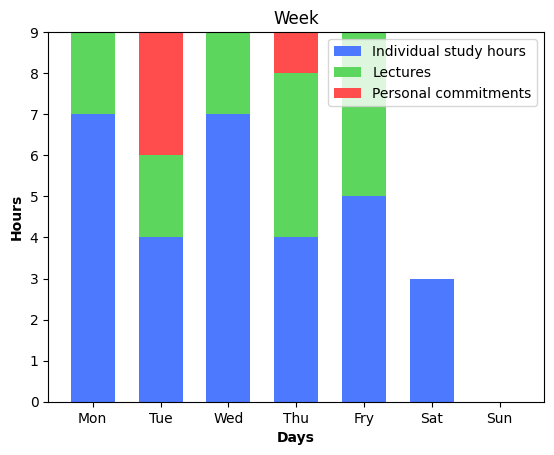

In [ ]:
# Choose the week to plot
i = 3

categories = ['Mon', 'Tue', 'Wed', 'Thu', 'Fry', 'Sat', 'Sun']
values1 = solution[i]  # Values for the individual study hours
values2 = lect[i]  # Values for the lecture hours
values3 = commit[i]  # Values for the commitments hours

# Plotting the bars
plt.bar(categories, values1, width=0.65, color='#4d79ff', label='Individual study hours')
plt.bar(categories, values2, width=0.65, bottom=values1, color='#5cd65c', label='Lectures')
plt.bar(categories, values3, width=0.65, bottom=[values1[j] + values2[j] for j in range(len(values1))], color='#ff4d4d', label='Personal commitments')

# Adding labels and title
plt.xlabel('Days', fontweight='bold')
plt.ylabel('Hours', fontweight='bold')
plt.title('Week')

# Adding a legend
plt.legend()


# Showing the plot
plt.show()



In [ ]:
data = solution
# Days of the week
days = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

# Set a fixed width for each column
col_width = 5

# Formatting the header
header = "| Week | " + " | ".join(f"{day:^{col_width}}" for day in days) + " |"
separator = "+" + "+".join("-" * (col_width + 2) for _ in range(len(days) + 1)) + "+"

# Printing the header
print(separator)
print(header)
print(separator)

# Printing each week with its data
for week_num, week_data in enumerate(data, start=1):
    week_str = f"| {week_num:4d} | " + " | ".join(f"{day:^{col_width}}" for day in week_data) + " |"
    print(week_str)
    print(separator)

+-------+-------+-------+-------+-------+-------+-------+-------+
| Week |  Mon  |  Tue  |  Wed  |  Thu  |  Fri  |  Sat  |  Sun  |
+-------+-------+-------+-------+-------+-------+-------+-------+
|    1 |   3   |   3   |   0   |   0   |   3   |   5   |   5   |
+-------+-------+-------+-------+-------+-------+-------+-------+
|    2 |   2   |   3   |   0   |   0   |   3   |   3   |   5   |
+-------+-------+-------+-------+-------+-------+-------+-------+
|    3 |   3   |   3   |   1   |   0   |   3   |   4   |   3   |
+-------+-------+-------+-------+-------+-------+-------+-------+
|    4 |   3   |   3   |   1   |   0   |   3   |   2   |   4   |
+-------+-------+-------+-------+-------+-------+-------+-------+
|    5 |   5   |   3   |   1   |   0   |   3   |   5   |   5   |
+-------+-------+-------+-------+-------+-------+-------+-------+
|    6 |   5   |   3   |   0   |   0   |   2   |   4   |   5   |
+-------+-------+-------+-------+-------+-------+-------+-------+
|    7 |   5   | 